<h1 id="Predict-on-Google-Cloud-ML-Engine">Predict on Google Cloud ML Engine</h1>

<p>tags: kaggle, digit, mnist, google cloud, ml-engline, ai-platform, predict, online, batch, json</p>

<p><a href="https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/" target="_blank">https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts</a></p>

<p><a href="https://github.com/googledatalab/notebooks/blob/991fba5b26b4cb2651e7d7c50ab65afeb5761219/samples/ML%20Toolbox/Regression/Census/5%20Service%20Predict.ipynb">https://github.com/googledatalab/notebooks/blob/991fba5b26b4cb2651e7d7c50ab65afeb5761219/samples/ML%20Toolbox/Regression/Census/5%20Service%20Predict.ipynb</a></p>


In [1]:
import os
import shutil
import gcsfs
from datetime import datetime

import json, codecs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
PROJECT = "________" # REPLACE WITH YOUR PROJECT ID
BUCKET = "________" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
TFVERSION = "1.13"


os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION  # Tensorflow version

In [ ]:
!gcloud auth list
!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION
!gcloud config list project
#!gcloud compute instances list

In [4]:
#deployed model
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"


## Create input test dataset 

In [5]:
# create json file from test iamges for predict

HEIGHT = 28
WIDTH = 28

#### input test data

test = pd.read_csv('../data/test.csv')
test_images = test.to_numpy().astype('float32')/255.0

test_images.shape


(28000, 784)

In [6]:
len(test_images)

28000

### Save json files once

In [7]:
IMGNO=5
JSON_DATA_5img="../data/test_5img.json" 

with open(JSON_DATA_5img, "w") as file:
    for i in range(IMGNO):
#        jsondata = {"image": test_images[i].reshape([HEIGHT,WIDTH]).tolist(), "key": i}
        file.write(json.dumps(jsondata) + '\n')

In [8]:
IMGNO=len(test_images)
JSON_DATA="../data/test_allimg.json"

with open(JSON_DATA, "w") as file:
    for i in range(IMGNO):
#        jsondata = {"image": test_images[i].reshape([HEIGHT,WIDTH]).tolist(), "key": i}
        file.write(json.dumps(jsondata) + '\n')

### Display test images

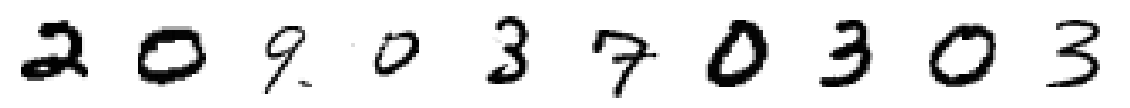

In [6]:
IMGNO=10
plt.figure(figsize=(20,5))
for i in range(IMGNO):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')


## Online prediction 

In [7]:
JSON_DATA_5img="../data/test_5img.json" 

In [8]:
!gcloud ai-platform predict \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --json-instances=$JSON_DATA_5img 

CLASS_IDS  KEY  PROBABILITIES
2          0    [2.157716695000791e-15, 7.120979500507829e-11, 1.0, 1.038207089743004e-10, 1.7021737997588372e-15, 4.439483310655775e-18, 1.1650549231953522e-13, 1.6309280315152108e-11, 2.8516189518219826e-13, 2.620594736747289e-16]
0          1    [0.9999995231628418, 1.5729922572815802e-11, 1.1480251060902447e-07, 3.4986682995175045e-10, 3.331811493367809e-10, 7.699960491436286e-08, 7.116546640872912e-08, 8.946547502830526e-09, 1.7725131584711562e-08, 1.3308539337231196e-07]
9          2    [6.248121464658141e-11, 1.2815258854104172e-09, 2.497069884199732e-09, 1.2406940363973717e-08, 3.862553057842888e-06, 8.85780546133752e-11, 1.1261413676577625e-11, 1.0637103642352486e-08, 2.0143168910635723e-07, 0.9999958276748657]
0          3    [0.9960324168205261, 2.177733327002329e-09, 0.0003500618040561676, 3.4856368529290194e-06, 5.254690904621384e-09, 1.2046750264005368e-08, 1.2734502661260194e-06, 1.9609587980085053e-06, 0.00020687119103968143, 0.003403953975

## Batch prediction

In [9]:
DATETIME=datetime.now().strftime("%Y%m%d_%H%M%S")
JOBNAME='pred_cnnt01_allimg_'+DATETIME

print("Jobname: ",JOBNAME)

Jobname:  pred_cnnt01_allimg_20190907_105047


In [10]:
INPDIR='gs://'+BUCKET+'/digit/data/test_allimg.json'
OUTDIR='gs://'+BUCKET+'/digit/data/pred_'+DATETIME+'/'

In [11]:
# upload test_allimg.json to gcloud or run the next line.

#!gsutil cp $JSON_DATA $INPDIR #this could take very long time.

In [12]:
!gcloud ai-platform jobs submit prediction $JOBNAME \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --data-format=TEXT \
    --region=$REGION \
    --input-paths=$INPDIR \
    --output-path=$OUTDIR

jobId: pred_cnnt01_allimg_20190907_105047
state: QUEUED


Job [pred_cnnt01_allimg_20190907_105047] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe pred_cnnt01_allimg_20190907_105047

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs pred_cnnt01_allimg_20190907_105047


In [ ]:
!gsutil ls $OUTDIR

In [20]:
PRED_LOCAL="../data/pred_"+DATETIME
os.mkdir(PRED_LOCAL)


In [21]:
PRED_LOCAL

'../data/pred_20190907_105047'

In [ ]:
#download multiple parts of the prediction 
#OUTDIR='gs://'+BUCKET+'/digit/data/prediction'
#PRED_LOCAL="../data/"

for i in range(8):
    PRED_CLOUD = OUTDIR + 'prediction.results-0000'+str(i)+'-of-00008'
    !gsutil cp $PRED_CLOUD $PRED_LOCAL

In [23]:
#PRED_LOCAL="../data"
pred_out=[]

for j in range(8):
    PRED_FILES=PRED_LOCAL+'/prediction.results-0000'+str(j)+'-of-00008'
    print('reading ', PRED_FILES)
    data = [json.loads(line) for line in open(PRED_FILES, 'r')]
    
    for i in range(len(data)):
        pred_out.append([data[i]['key'],data[i]['class_ids']])


reading  ../data/pred_20190907_105047/prediction.results-00000-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00001-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00002-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00003-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00004-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00005-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00006-of-00008
reading  ../data/pred_20190907_105047/prediction.results-00007-of-00008


In [24]:
np.shape(pred_out)

(28000, 2)

In [25]:
pred_out[:10]

[[10851, 4],
 [10852, 1],
 [10853, 9],
 [10854, 7],
 [10855, 2],
 [10856, 0],
 [10857, 8],
 [10858, 2],
 [10859, 4],
 [10860, 3]]

In [26]:
pred_out = sorted(pred_out,key=lambda x:x[0])

In [27]:
pred=np.array(pred_out)[:,1]
pred_key=np.array(pred_out)[:,0]

In [28]:
# correct order from 1000: [0, 7, 0, 7, 1, 3, 4, 6, 3, 9]
pred[1000:1010]

array([0, 7, 0, 7, 1, 3, 4, 6, 3, 9])

In [29]:
pred_key[1000:1010]

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009])

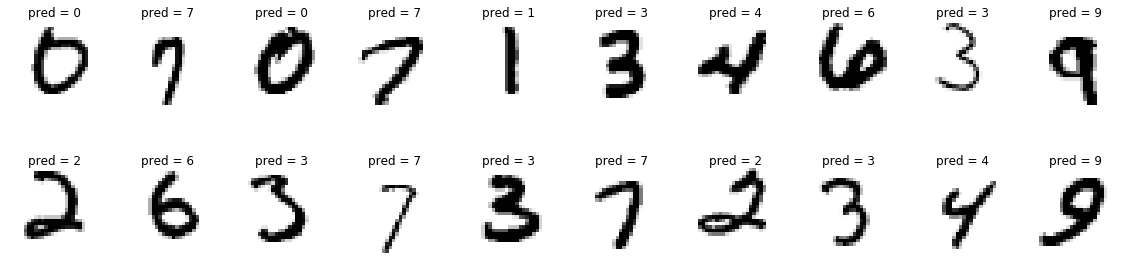

In [30]:
i=1000
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(test_images[IMGNO].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("pred = %d" % pred[IMGNO],y=0.9)
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [31]:
output = pd.DataFrame({ 'ImageId' : pred_key+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [32]:
output.to_csv('../data/sub_digit_cnn_estimator_v05_gcp_30ep.csv', index = False)

<h2 id="Next-steps">Next steps</h2>

<p>&nbsp;</p>

<ol>
	<li>recreat tf record&nbsp;<a href="https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/create_records.py" target="_blank">https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/create_records.py</a></li>
</ol>
